# Importación de librerias

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
import numpy as np
import optuna
from scripts import *

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style='whitegrid', palette='muted', font_scale=1.1)
sns.set_context("notebook", rc={"figure.figsize": (12, 6)})

In [3]:
n_trials = 100
n_jobs = 1

In [4]:
full_dataset_path = './datasets/full_dataset.parquet'

In [5]:
future_periods = ['202001', '202002']
test_periods = ['201912']

# Carga de datasets

In [6]:
df_full = pd.read_parquet(full_dataset_path)

In [7]:
df_train_test = df_full[~df_full['periodo'].isin(future_periods)]

In [8]:
df_train = df_train_test[~df_train_test['periodo'].isin(test_periods)]
df_test = df_train_test[df_train_test['periodo'].isin(test_periods)]
# df_future = df_full[df_full['periodo'].isin(future_periods)]

In [9]:
del df_full
del df_train_test

In [10]:
features = [col for col in df_train.columns if col not in ['tn', 'periodo', 'periodo_dt', 'year', 'customer_id', 'product_id', 'customer_id_limited', 'product_id_limited']]

In [11]:
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'customer_id_limited_encoded', 'product_id_limited_encoded']

In [12]:
X_train = df_train[features]
y_train = df_train['tn']

In [13]:
df_train['periodo'] = df_train['periodo'].astype(str)
df_test['periodo'] = df_test['periodo'].astype(str)

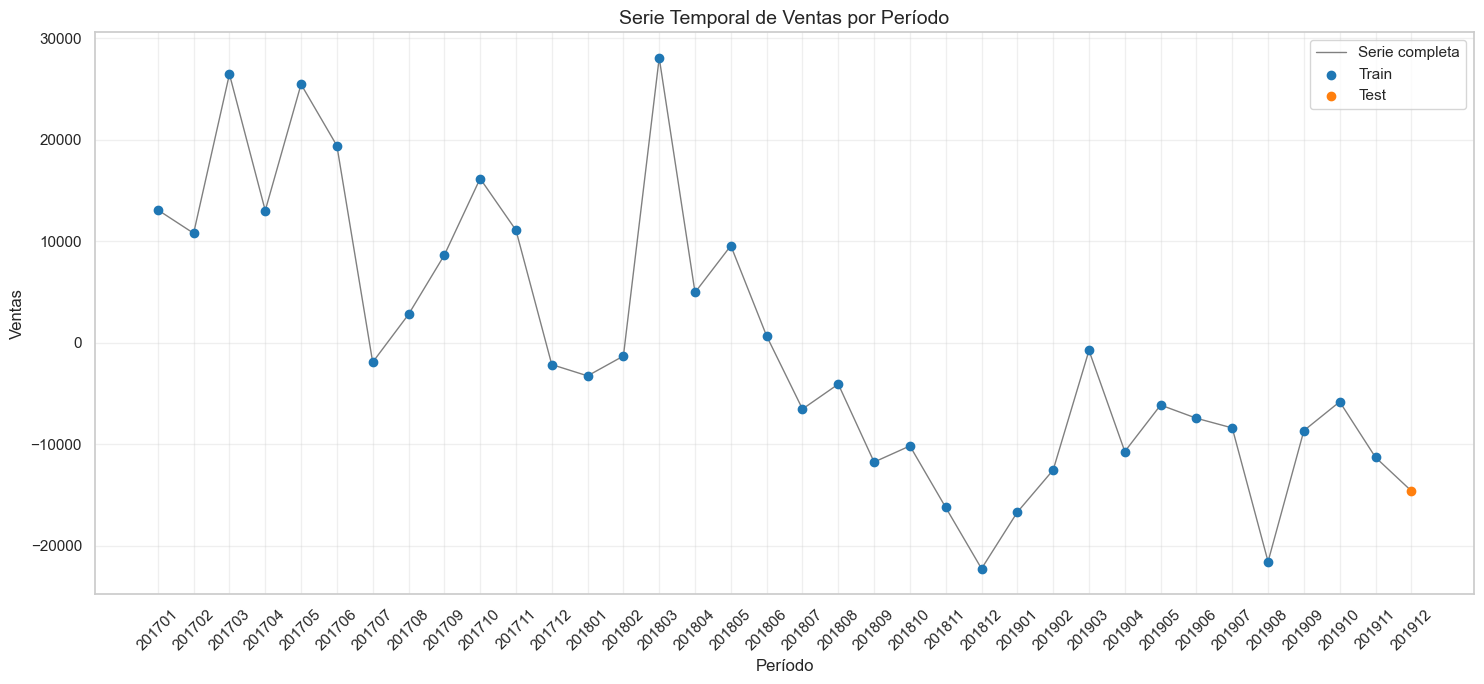

In [14]:
ts_train = df_train.groupby('periodo')[['tn']].sum()
ts_test = df_test.groupby('periodo')[['tn']].sum()

ts_all = pd.concat([ts_train, ts_test])

plt.figure(figsize=(15, 7))

plt.plot(ts_all.index, ts_all.values, color='gray', linewidth=1, label='Serie completa')

plt.scatter(ts_train.index, ts_train.values, color='tab:blue', label='Train', zorder=3)
plt.scatter(ts_test.index, ts_test.values, color='tab:orange', label='Test', zorder=3)

plt.title('Serie Temporal de Ventas por Período', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Ventas', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
df_train['periodo'] = df_train['periodo'].astype('category')
df_test['periodo'] = df_test['periodo'].astype('category')

# Entrenar modelo

In [16]:
def objective(trial):
    params = {
        'device': 'gpu',
        'max_bin': 255,
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'verbose': -1
    }

    print(f"Trial {trial.number}")

    tfe_scores = []

    sorted_periods = sorted(df_train['periodo'].unique())
    train_window = 12
    val_window = 1

    for i in range(len(sorted_periods) - train_window - val_window + 1):        
        train_periods = sorted_periods[i : i + train_window]
        val_periods = sorted_periods[i + train_window : i + train_window + val_window]

        train_mask = df_train['periodo'].isin(train_periods)
        val_mask = df_train['periodo'].isin(val_periods)

        X_train_wf = X_train[train_mask]
        y_train_wf = y_train[train_mask]
        X_val_wf = X_train[val_mask]
        y_val_wf = y_train[val_mask]

        if X_train_wf.empty or X_val_wf.empty:
            continue

        train_data_wf = lgb.Dataset(X_train_wf, label=y_train_wf, categorical_feature=categorical_cols)
        val_data_wf = lgb.Dataset(X_val_wf, label=y_val_wf, categorical_feature=categorical_cols)

        model_wf = lgb.train(
            params,
            train_set=train_data_wf,
            valid_sets=[val_data_wf],
            num_boost_round=500,
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        y_pred_wf = model_wf.predict(X_val_wf)

        tfe = np.sum(y_val_wf - y_pred_wf) / np.sum(y_val_wf)
        tfe_scores.append(abs(tfe))

        print(f"Finalizado ciclo {i} de {len(sorted_periods) - train_window - val_window + 1} - TFE: {tfe:.3f}")

    print(f"TFE avg: {np.mean(tfe_scores):.3f}")

    return np.mean(tfe_scores)

In [18]:
study_name = 'lightgbm_forecast_opt'
storage = 'sqlite:///optuna.db'

study = optuna.create_study(
    direction='minimize',
    study_name=study_name,
    storage=storage,
    load_if_exists=True
)

[I 2025-06-23 13:39:24,638] Using an existing study with name 'lightgbm_forecast_opt' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs, show_progress_bar=True)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)

In [19]:
best_params = study.best_params
best_params

{'max_depth': 10,
 'learning_rate': 0.16361802724610255,
 'num_leaves': 93,
 'min_data_in_leaf': 48,
 'feature_fraction': 0.9957131454686399,
 'bagging_fraction': 0.9019655021891562,
 'bagging_freq': 5,
 'n_estimators': 359,
 'min_child_weight': 4,
 'subsample': 0.8081805806591077,
 'colsample_bytree': 0.8731581481414598,
 'reg_alpha': 0.38113611905337297,
 'reg_lambda': 0.678919227544678}

In [20]:
X_test = df_test[features]
y_test = df_test['tn']

In [21]:
train_data_final = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
test_data_final = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_cols)

In [22]:
model = lgb.train(
    best_params,
    train_set=train_data_final,
    valid_sets=[test_data_final],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

[LightGBM] [Warning] bagging_fraction is set=0.9019655021891562, subsample=0.8081805806591077 will be ignored. Current value: bagging_fraction=0.9019655021891562
[LightGBM] [Warning] feature_fraction is set=0.9957131454686399, colsample_bytree=0.8731581481414598 will be ignored. Current value: feature_fraction=0.9957131454686399
[LightGBM] [Warning] bagging_fraction is set=0.9019655021891562, subsample=0.8081805806591077 will be ignored. Current value: bagging_fraction=0.9019655021891562
[LightGBM] [Warning] feature_fraction is set=0.9957131454686399, colsample_bytree=0.8731581481414598 will be ignored. Current value: feature_fraction=0.9957131454686399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.046572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36567
[LightGBM] [Info] Number of data points in the train set: 15199758, number of

In [23]:
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [24]:
tfe_train = np.abs(np.sum(y_train - y_pred_train) / np.sum(y_train))
tfe_test = np.abs(np.sum(y_test - y_pred_test) / np.sum(y_test))

print(f'Total Forecast Error en entrenamiento: {tfe_train:.4f}')
print(f'Total Forecast Error en prueba: {tfe_test:.4f}')

Total Forecast Error en entrenamiento: 2172.9038
Total Forecast Error en prueba: 0.4857


In [25]:
y_pred_train = pd.DataFrame(y_pred_train, columns=['predicciones'], index=X_train.index)
y_pred_test = pd.DataFrame(y_pred_test, columns=['predicciones'], index=X_test.index)

In [26]:
y_pred_test

,predicciones
15199758,-0.106647
15199759,-0.098357
15199760,-0.195403
15199761,-0.134529
15199762,-0.090896
...,...
15601217,-0.085029
15601218,-0.157493
15601219,3.002268
15601220,-0.165216


In [27]:
df_train.loc[df_train.index, 'predicciones'] = y_pred_train['predicciones']
df_test.loc[df_test.index, 'predicciones'] = y_pred_test['predicciones']

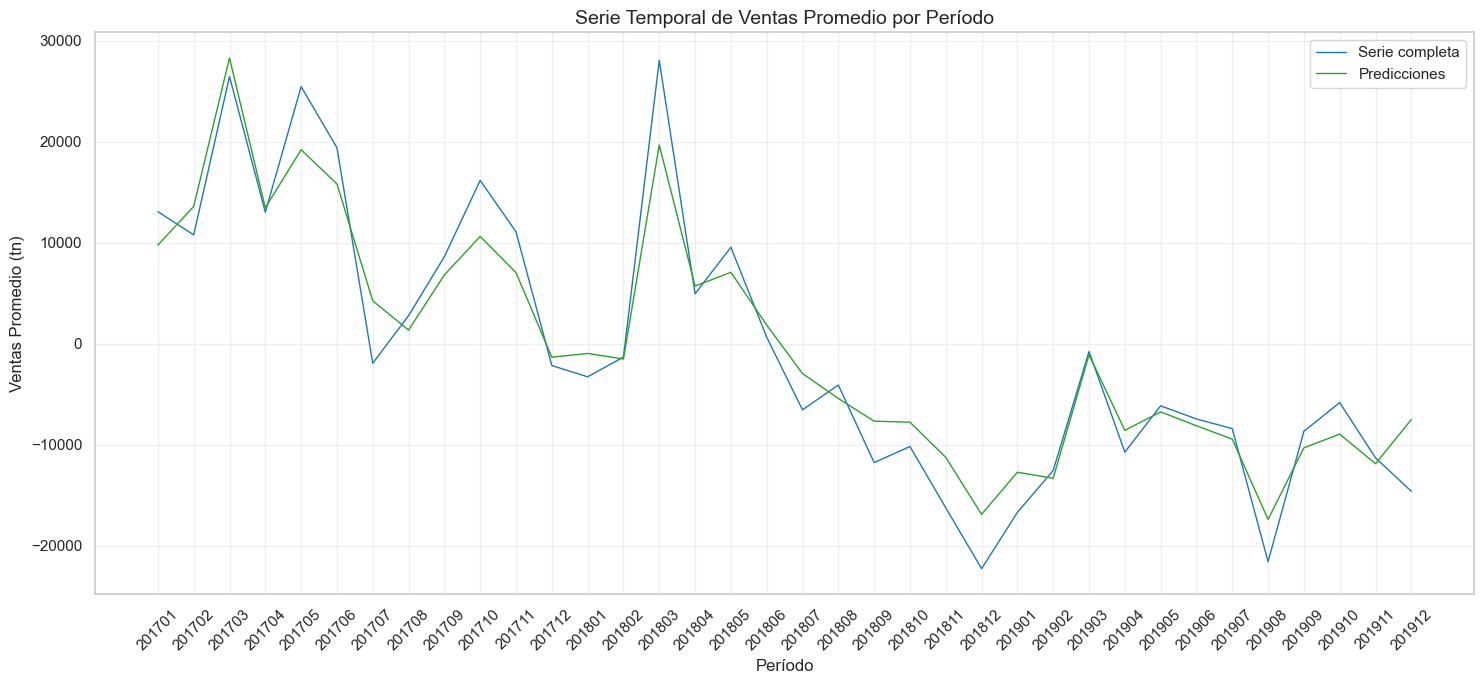

In [28]:
df_train['periodo'] = df_train['periodo'].astype(str)
df_test['periodo'] = df_test['periodo'].astype(str)

ts_train = df_train.groupby('periodo')[['tn', 'predicciones']].sum()
ts_test = df_test.groupby('periodo')[['tn', 'predicciones']].sum()

ts_all = pd.concat([ts_train, ts_test])

plt.figure(figsize=(15, 7))

plt.plot(ts_all.index, ts_all['tn'], color='tab:blue', linewidth=1, label='Serie completa')
plt.plot(ts_all.index, ts_all['predicciones'], color='tab:green', linewidth=1, label='Predicciones')

plt.title('Serie Temporal de Ventas Promedio por Período', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Ventas Promedio (tn)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
df_train['periodo'] = df_train['periodo'].astype('category')
df_test['periodo'] = df_test['periodo'].astype('category')

In [30]:
model.save_model('modelo_lgb.txt')
print("Modelo guardado exitosamente como 'modelo_lgb.txt'")

Modelo guardado exitosamente como 'modelo_lgb.txt'


# Feature importance

In [31]:
feature_names = model.feature_name()

importance_gain = model.feature_importance(importance_type='gain')
importance_split = model.feature_importance(importance_type='split')

df_importance = pd.DataFrame({
    'feature': feature_names,
    'gain': importance_gain,
    'split': importance_split
}).sort_values(by='gain', ascending=False)

df_importance.head(50)

,feature,gain,split
47,tn_lag_1,8.999740e+06,155
48,tn_lag_2,3.921620e+06,238
225,customer_id_limited_encoded,2.486397e+06,1126
49,tn_lag_3,1.419742e+06,207
50,tn_lag_4,8.130677e+05,166
226,product_id_limited_encoded,7.965262e+05,975
2,cat3,7.463456e+05,912
4,sku_size,6.782022e+05,892
52,tn_lag_6,3.720824e+05,170
51,tn_lag_5,3.407688e+05,174


In [32]:
# Obtener las características con ganancia (gain) igual a 0
features_to_remove = df_importance[df_importance['gain'] == 0]['feature'].tolist()

print("Features a eliminar (gain = 0):")
for feature in features_to_remove:
    print(f"- {feature}")

Features a eliminar (gain = 0):
- tn_is_max_12
- tn_is_max_18
- tn_is_max_17
- tn_is_max_16
- tn_is_max_15
- tn_is_max_14
- tn_is_max_11
- tn_is_max_4
- tn_is_max_19
- tn_is_max_9
- tn_is_max_8
- tn_is_max_7
- tn_is_max_6
- tn_is_max_5
- tn_is_max_10
- tn_is_max_35
- tn_is_max_36
- tn_is_max_21
- tn_is_max_22
- tn_is_max_23
- tn_is_max_24
- tn_is_max_25
- tn_is_max_26
- tn_is_max_27
- tn_is_max_28
- tn_is_max_29
- tn_is_max_30
- tn_is_max_31
- tn_is_max_32
- tn_is_max_33
- tn_is_max_34
- tn_is_max_20
- tn_std_1
- tn_is_min_36
- tn_is_min_35
- tn_is_min_15
- tn_is_min_14
- tn_is_min_13
- tn_is_min_12
- tn_is_min_11
- tn_is_min_10
- tn_is_min_9
- tn_is_min_8
- tn_is_min_6
- tn_is_min_5
- tn_is_min_4
- tn_is_min_3
- tn_delta_lag_34
- tn_delta_lag_35
- tn_ma_1
- tn_is_min_16
- tn_is_min_17
- tn_is_min_18
- tn_is_min_28
- tn_is_min_34
- tn_is_min_33
- tn_is_min_32
- tn_is_min_31
- tn_is_min_30
- tn_is_min_29
- tn_is_min_27
- tn_is_min_20
- tn_is_min_26
- tn_is_min_25
- tn_is_min_24
- tn_is_

In [33]:
df_importance.head(25)

,feature,gain,split
47,tn_lag_1,8.999740e+06,155
48,tn_lag_2,3.921620e+06,238
225,customer_id_limited_encoded,2.486397e+06,1126
49,tn_lag_3,1.419742e+06,207
50,tn_lag_4,8.130677e+05,166
226,product_id_limited_encoded,7.965262e+05,975
2,cat3,7.463456e+05,912
4,sku_size,6.782022e+05,892
52,tn_lag_6,3.720824e+05,170
51,tn_lag_5,3.407688e+05,174


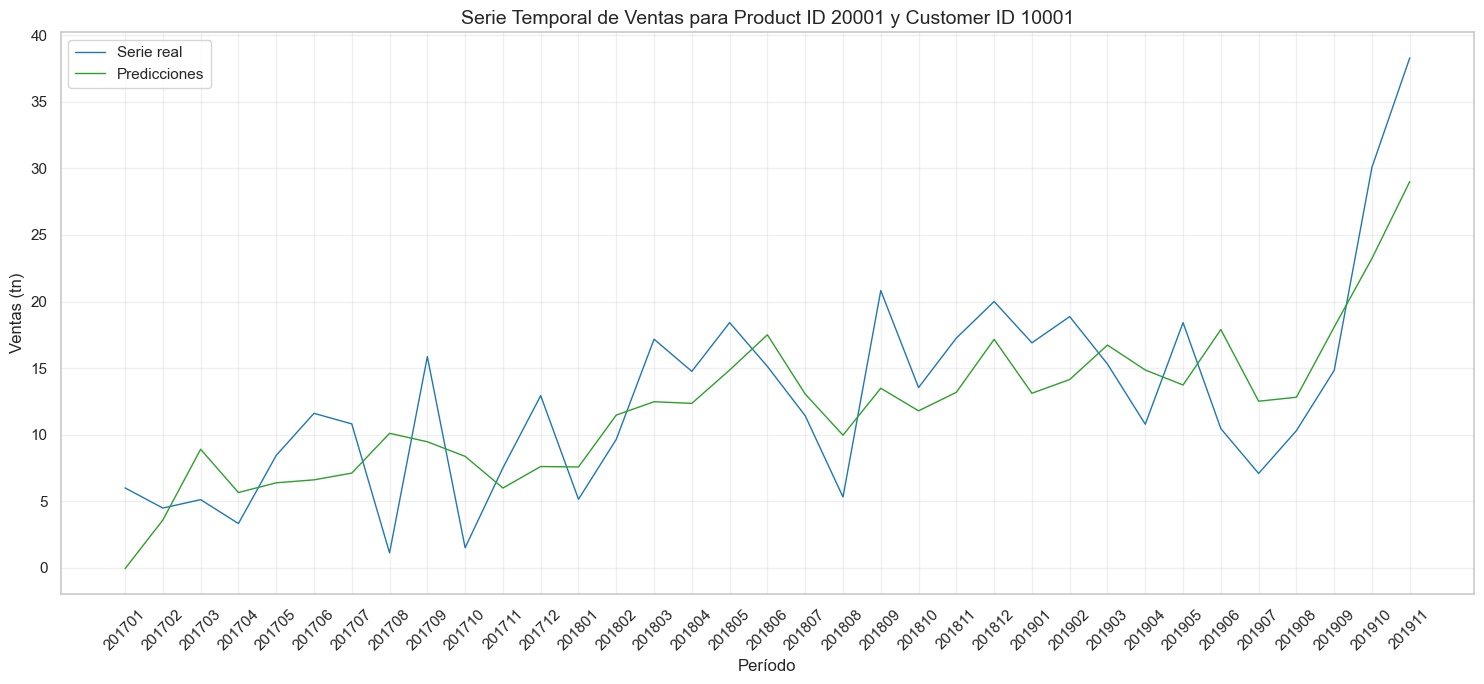

In [34]:
product_id = '20002'
customer_id = '10001'

df_train['periodo'] = df_train['periodo'].astype(str)
df_test['periodo'] = df_test['periodo'].astype(str)

df_filtered = df_train[
    (df_train['product_id'] == product_id) & 
    (df_train['customer_id'] == customer_id)
]

plt.figure(figsize=(15, 7))

plt.plot(df_filtered['periodo'], df_filtered['tn'], color='tab:blue', linewidth=1, label='Serie real')
plt.plot(df_filtered['periodo'], df_filtered['predicciones'], color='tab:green', linewidth=1, label='Predicciones')

plt.title('Serie Temporal de Ventas para Product ID 20001 y Customer ID 10001', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Ventas (tn)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_train['periodo'] = df_train['periodo'].astype('category')
df_test['periodo'] = df_test['periodo'].astype('category')